# 1. Summary

Context: For this project, I explored the relationship between different sentiment measures that were calculated through analyzing 10-K filings and stock returns for the companies in the S&P 500 index. In total, there are 10 sentiment variables, 5 total sentiment methods each having it's positive and negative sentiment variable. The main two sentiment methods (4 variables) were derived using two different sentiment dictionaries provided to me (LM and ML), which had classifications of "positive" and "negative" words. The other 3 methods (6 variables) were contextual sentiment methods that were allocating a sentiment score (for both the positive and negative variables) based on each company's financial performance wordings, geopolitical conditions/risk wordings, and business competition landscape wordings. I then compared each firm's sentiment score with stock price performance around the filing date. 

Findings: My results generally showed a weak correlation between the sentiment variables and stock price returns around the filing date. The LM and ML positive and negative sentiment measures showed a very minimal association with the returns, especially during the filing date or just a few days after the filing date. On the other hand, the contextual sentiment measures focusing on financial, geopolitical and competitive aspects showed some variation but still lacked strong predictive power. Some contextual sentiment measures such as competitive positive sentiment had a very small positive correlation with returns, but the overall relationships were very weak and didn't make any storng claims.
The overall project findings showed me that while sentiment may play a role in stock price movement, there are other factors that have much weightier controbutions to the price returns.


# 2. DATA Section

Sample
The sample data is for all S&P 500 firms that submitted a 10-K filing between January 1st and December 31st, 2022. A total of 498 10-K files were then analyzed. In the get_text_files_zipAFTER.pyn file, I started by importing all the relevant libraries such as glob for data management and sec_edgar_downloader to access the various 10-K filings on the SEC's website. I checked whether the file existed, and if not then scraped and saved the data from a revision of Wikipedia's S&P 500 list using the December 2022 version of the page. My script iterated over each company's CIK using the tqdm function, and then constructed a folder in line with the proper SEC formatting. I also checked for if any HTML 10-K files existed and if not then fetched it using dl.get(...) with after="2022-01-01" and before="2022-12-31". After downloading the 10-Ks, I deleted all .txt files in order to save space. I also further compressed the files to a 10k_files.zip folder, and then moved it into the 10k_files directory.


Return variables
Because I had trouble with my 10-K identifier code, I decided to go with the random generation for returns variables. The code for simulating "fake" returns was referenced from the professor, who had provided it on the midterm discussion board. Random returns were geneated for three types: return on the day of 10-k filing, return from day t to day t+2, and return from day t +3 to day t + 10. 


Sentiment variables
The two main sentiments were the LM (Loughran-McDonald) and ML (Machine Learning-based) sentiment variables that had both positive and negative sentiment values. For both the LM and ML methods, I referenced the class code on the Build_Sample_Exercises file initially, and then made several modifications. The key modifications I made and their explanations are below: When I run the following code:


When I ran the following code:

#print("LM Positive:", len(sentiment_words['LM_positive']))
#print("LM Negative:", len(sentiment_words['LM_negative']))
#print("ML Positive:", len(sentiment_words['ML_positive']))
#print("ML Negative:", len(sentiment_words['ML_negative']))

I got the following word counts:

- LM Positive: 345
- LM Negative: 2305
- ML Positive: 75
- ML Negative: 94

Modification 1: Created a load_sentiment_words() function
I created a reusable load_sentiment_words() function to load sentiment words from the ML and LM sentiment dictionaries. The LM dictionary was filtered to only include words that were tagged as relevant for the year 2009, which aligns with academic convention for sentiment analysis. I specifically excluded words that had "0" in both the positive and negative columns of the LM CSV file, as those were neutral and not useful for sentiment analysis. This approach ensures the code is clean, self-contained, and testable, in line with the best practices mentioned in the textbook.

The code for this modification was:


def load_sentiment_words():
    """
    Load and return sentiment word dictionaries (LM and ML).
    Filters LM dictionary to include only words tagged as relevant in 2009.
    """
    # Load ML positive and negative lists (already curated)
    with open('ML_negative_unigram.txt', 'r') as f:
        ML_negative = f.read().splitlines()

    with open("ML_positive_unigram.txt", "r", encoding="utf-8") as f:
        ML_positive = f.read().splitlines()

    # Filter LM negative words: only include those with 2009 tag
    LM_negative = []
    with open("LM_MasterDictionary_1993-2021.csv", "r", encoding="utf-8") as f:
        reader = csv.reader(f)
        next(reader)
        for row in reader:
            if row and row[1] == '2009':
                LM_negative.append(row[0])

    # Filter LM positive words: 2009 only
    LM_positive = []
    with open("LM_MasterDictionary_1993-2021.csv", "r", encoding="utf-8") as f:
        reader = csv.reader(f)
        next(reader)
        for row in reader:
            if row and row[2] == '2009':
                LM_positive.append(row[0])

    return {
        'LM_positive': LM_positive,
        'LM_negative': LM_negative,
        'ML_positive': ML_positive,
        'ML_negative': ML_negative
    }


# Modification 2: Calculating Positive Sentiment Ratios

I did this because the raw sentiment scores themselves are sensitive to document length. naturally, longer 10-ks will have more of all words and hence a great score allocated to them. Calculating a ratio standardises the results and normalizes for document size, painting a clearer picture. In the code, I made sure to avoide dividing by zero using conditional logic code. Although i'd expected varying results, I was quite shocked by how the firms had a very smilar positive sentiment ratio across the board

# Calculate ratios (optional but useful for comparability across documents)
lm_total = sentiment_LM_pos + sentiment_LM_neg
ml_total = sentiment_ML_pos + sentiment_ML_neg

lm_positive_ratio = sentiment_LM_pos / lm_total if lm_total != 0 else 0
ml_positive_ratio = sentiment_ML_pos / ml_total if ml_total != 0 else 0


# Modification 3: Clearning HTML using BeautifulSoup and Regex

Before any data cleaning, I sampled a few 10-k files to identify parts of the text that I can filter out to make the raw text less polluted. There were HTML tags, special characters, numbers, unwanted formatting, links, symbols, excessive commas and other "noise" items. After cleaning, I found the precision of word matching to improve greatly for sentiment scoring. For this, I used regex and string operations to clean the data withough over-cleaning / removing valuable content in the text. 

def clean_html_text(text):
    text = re.sub(r'http[s]?://\S+', '', text)
    text = re.sub(r'[\n\r\t0-9\-\●]+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.replace('\u200b', '')
    text = re.sub(r'[\u2122\u00AE]', '', text)
    text = text.replace('⌧', '')
    text = re.sub(r',+', ',', text)
    return text.strip()




# Contextual Sentiment Analysis

I decided to go with the following contextual sentiment approaches:

1. Financial Performance: A company's financial performance is a key driver of it's stock price. After all, no one wants to take an equity investment in a firm that is losing money or is in a downard trajectory. Given how ig the S&P 500 list is, I assumed that there will be companies that might have significantly positive or negative wordings when it comes to their financials. The words I chose for this from the ML list are:  

good_financial_positive = ['growth', 'outperformance', 'exceeded', 'record']
good_financial_negative = ['underperformance', 'declined', 'weakness', 'loss']

2. Geopolitical Impact: It is o surprise that 2022 was a historical year when it came to geopolitical conditions. The Russia/Ukraine war, lingering effects of Covid, rising inflation and interest rates across the world and more certainly created a frothy geopolitical environment for many of the S&P 500 companies. Hence, I screened for words that could be related to "geopolitics" such as unexpected. The words chosen were: 

ideal_geopolitical_positive = ['favorable', 'momentum']
ideal_geopolitical_negative = ['unexpected', 'challenging']

3. Business Competition: A business with a solid moat around its castle will be an attractive company and it's share price movements will reflect that strength. During 2021, a lot of big companies underwent financial distress. This led to financial bankruptcy for many, but also the emergence of "stronger" firms that doubled down on their competitive advantages and weeded out the competition. The words I chose for this were:  

strong_competitive_positive = ['strength', 'solid']
strong_competitive_negative = ['pressures', 'challenges']

After this was set up, I proceeded to Measure the contextual sentiment. I implemented a regex approach using the re module to scan the cleanred 10-k text for the exact matches of the sentiment specific words listed above. I applied word boundary patterns so that the matches only targetted complete words and not making critical errors (for example matching growth but not regrowth). Lastly, I capped each score at 10 in order to keep the scores intepratable by anyone looking at the data/ code. Based on the textbook guidance, this approach is dynamic and can be extended by easily updating the world lists or even changing the regex for a more advanced analysis. 

def calculate_contextual_sentiment(text, topic_positive_words, topic_negative_words):
    """
    Calculate contextual sentiment score based on presence of specific topic words.
    """
    positive_hits = len(re.findall(r'\b(' + '|'.join(topic_positive_words) + r')\b', text.lower()))
    negative_hits = len(re.findall(r'\b(' + '|'.join(topic_negative_words) + r')\b', text.lower()))

    positive_score = min(10, positive_hits)  # Cap scores
    negative_score = min(10, negative_hits)
    return positive_score, negative_score




# Summary Statistics

In [12]:
import pandas as pd

df = pd.read_csv("output/analysis_sample.csv")
cols_to_summarize = [col for col in df.columns if "Positive" in col or "Negative" in col or "ret_" in col]
df[cols_to_summarize].describe()

,LM_Positive,LM_Negative,ML_Positive,ML_Negative,Financial_Positive_Score,Financial_Negative_Score,Geopolitical_Positive_Score,Geopolitical_Negative_Score,Competitive_Positive_Score,Competitive_Negative_Score,LM_Positive_Ratio,ML_Positive_Ratio,ret_t0,ret_t0_t2,ret_t2_t10
count,4.980000e+02,4.980000e+02,4.980000e+02,4.980000e+02,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000
mean,7.561134e+06,4.175550e+07,1.354636e+06,1.762818e+06,9.991968,9.951807,6.708835,4.582329,3.321285,7.331325,0.153144,0.434459,0.011400,0.022519,0.096883
std,3.267973e+06,1.773044e+07,5.800912e+05,7.501627e+05,0.141619,0.543562,3.296477,2.630545,3.111152,2.995749,0.001535,0.002149,0.980438,0.978562,1.004289
min,9.095810e+05,5.129488e+06,1.657350e+05,2.107670e+05,7.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.149336,0.428780,-3.241267,-2.696887,-2.896255
25%,5.699227e+06,3.149243e+07,1.019658e+06,1.328676e+06,10.000000,10.000000,4.000000,3.000000,1.000000,5.000000,0.152239,0.433296,-0.689688,-0.612471,-0.604554
50%,6.951175e+06,3.853609e+07,1.250708e+06,1.630290e+06,10.000000,10.000000,7.000000,4.000000,2.000000,8.000000,0.153025,0.434080,0.017003,0.026488,0.104788
75%,8.486916e+06,4.673858e+07,1.516904e+06,1.979257e+06,10.000000,10.000000,10.000000,6.000000,5.000000,10.000000,0.153851,0.435243,0.642512,0.649828,0.731387
max,2.748418e+07,1.501586e+08,4.964775e+06,6.437331e+06,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.163580,0.453580,3.852731,2.632382,2.601683


Intepretation of summary statistics: There are several interesting insights about the dataset from the summary statistics table above. Firstly, the LM sentiment scores are significantly greater than the ML scores. I think this discrepency is because the LM dictionary is simply larger and tracks more words as positive and negative. The positive and negative sentiment ratios also tell me that while firms in general report more neautral or negative wording, the ML picks up more positive text in general. 

For the xontextual sentiment scores (o to 10), I found some interesting results: 

1. The Financial_Positive_Score had a mean of 9.99 with a very low standard deviation. This tells me that all firms use highly positive language when it comes to their financials, even if the company is actually not doing that well. This seems a bit fishy to me, but I also understand that a negative tone on the financial could cause an investor exodus. Hence, the question is more about ethics and whether it's right to make a situation seem better than it is, especially since financial metrics such a s"Adjusted EBITDA" can easily be tailored to support a specific story.

2. Interestingly, the negative scores for Geopolitics and Business Competition showed more variability (standard deviation of around 3.3 and 3.1) which signals that company tone can vary substantially depending on the topic being discussed.

The Geopolitical_Negative_Score has a mean of 4.58 and a max of 10, which reflects 2022's volatile macroneconomic environment, including war and inflation. Although it doesn't look like the returns are significantly correlated with the sentiments / sentiment scores. 

3. Looking at the returns, the mean is close to zero, which makes sense since I had randomly generated variables (which are typically centered around mean 0). However, both ret_t0_t2 and ret_t2_t10 show higher means and standard deviations above 1, which I find a bit funny as they replicate wider price movements post 10-k release as investors digest firm disclosures. ALthough in this case, it was a oure conincidence since the returns were randomly generated.

Overall, I think the contextual sentiment variables do pass basic smell tests. There is clear variation in the scores, which range from 0 to 10, indicating that the sentiment measures are not constant. They also tell a story, for example the high mean score of Financial_Positive_Score (9.99) tells me that firms like to highlight strength and growth consistentyly, making the 10-k reports aimed at reassuring investors. There is also more spread in Geopolitical and Competitive sentiment, which suggests that not all firms are equally optimistic in other topics. This alligns with reality, as firms in supply chain, commodities and other sensitive sectors might be more exposed to undertainty. 
No immediate red flags appear. There is no clustering at a single value. The potential shortfalls are my own, such as capping the score limit at 10. 


Caveats: There are some cavteas to note. Firstly, while the data is very robust, the LM and ML dictionaries have extremely high counts. There could be repeated languages that are inflating frequency without actuall adding any sentiment nuance. Secondly, the sentiment ratio variables, althoughnormalized due show very little variation (especially LM_Positive_Ratio). This could be a problem for further analysis, such as limiting explanatory value in regression analysis. Moreover, because I capped the contextual sentiment scores at 10, some firms with much more sentiment-heavy language aren't distinguishable from those who just pass the threshold. This should deinitely be further explored in future work, either by increasing the cap or using another type of scoring method such as relative scoring. Lastly, the biggest caveat is that the returns are all simulated data and reflect "white noise" rather than actual market behaviour. In a more accurate analysis, the return calculations based on actual price movements might reveal a completely difference picture. 

# 3. Results

In [16]:
sentiment_cols = [
    'LM_Positive', 'LM_Negative',
    'ML_Positive', 'ML_Negative',
    'Financial_Positive_Score', 'Financial_Negative_Score',
    'Geopolitical_Positive_Score', 'Geopolitical_Negative_Score',
    'Competitive_Positive_Score', 'Competitive_Negative_Score'
]

return_cols = ['ret_t0', 'ret_t0_t2']

correlation_table = df[sentiment_cols + return_cols].corr().loc[sentiment_cols, return_cols]
correlation_table.round(3)

,ret_t0,ret_t0_t2
LM_Positive,0.025,0.007
LM_Negative,0.027,0.009
ML_Positive,0.027,0.008
ML_Negative,0.026,0.009
Financial_Positive_Score,-0.070,-0.014
Financial_Negative_Score,0.013,0.028
Geopolitical_Positive_Score,0.038,-0.042
Geopolitical_Negative_Score,0.058,-0.014
Competitive_Positive_Score,0.015,0.007
Competitive_Negative_Score,0.092,0.021


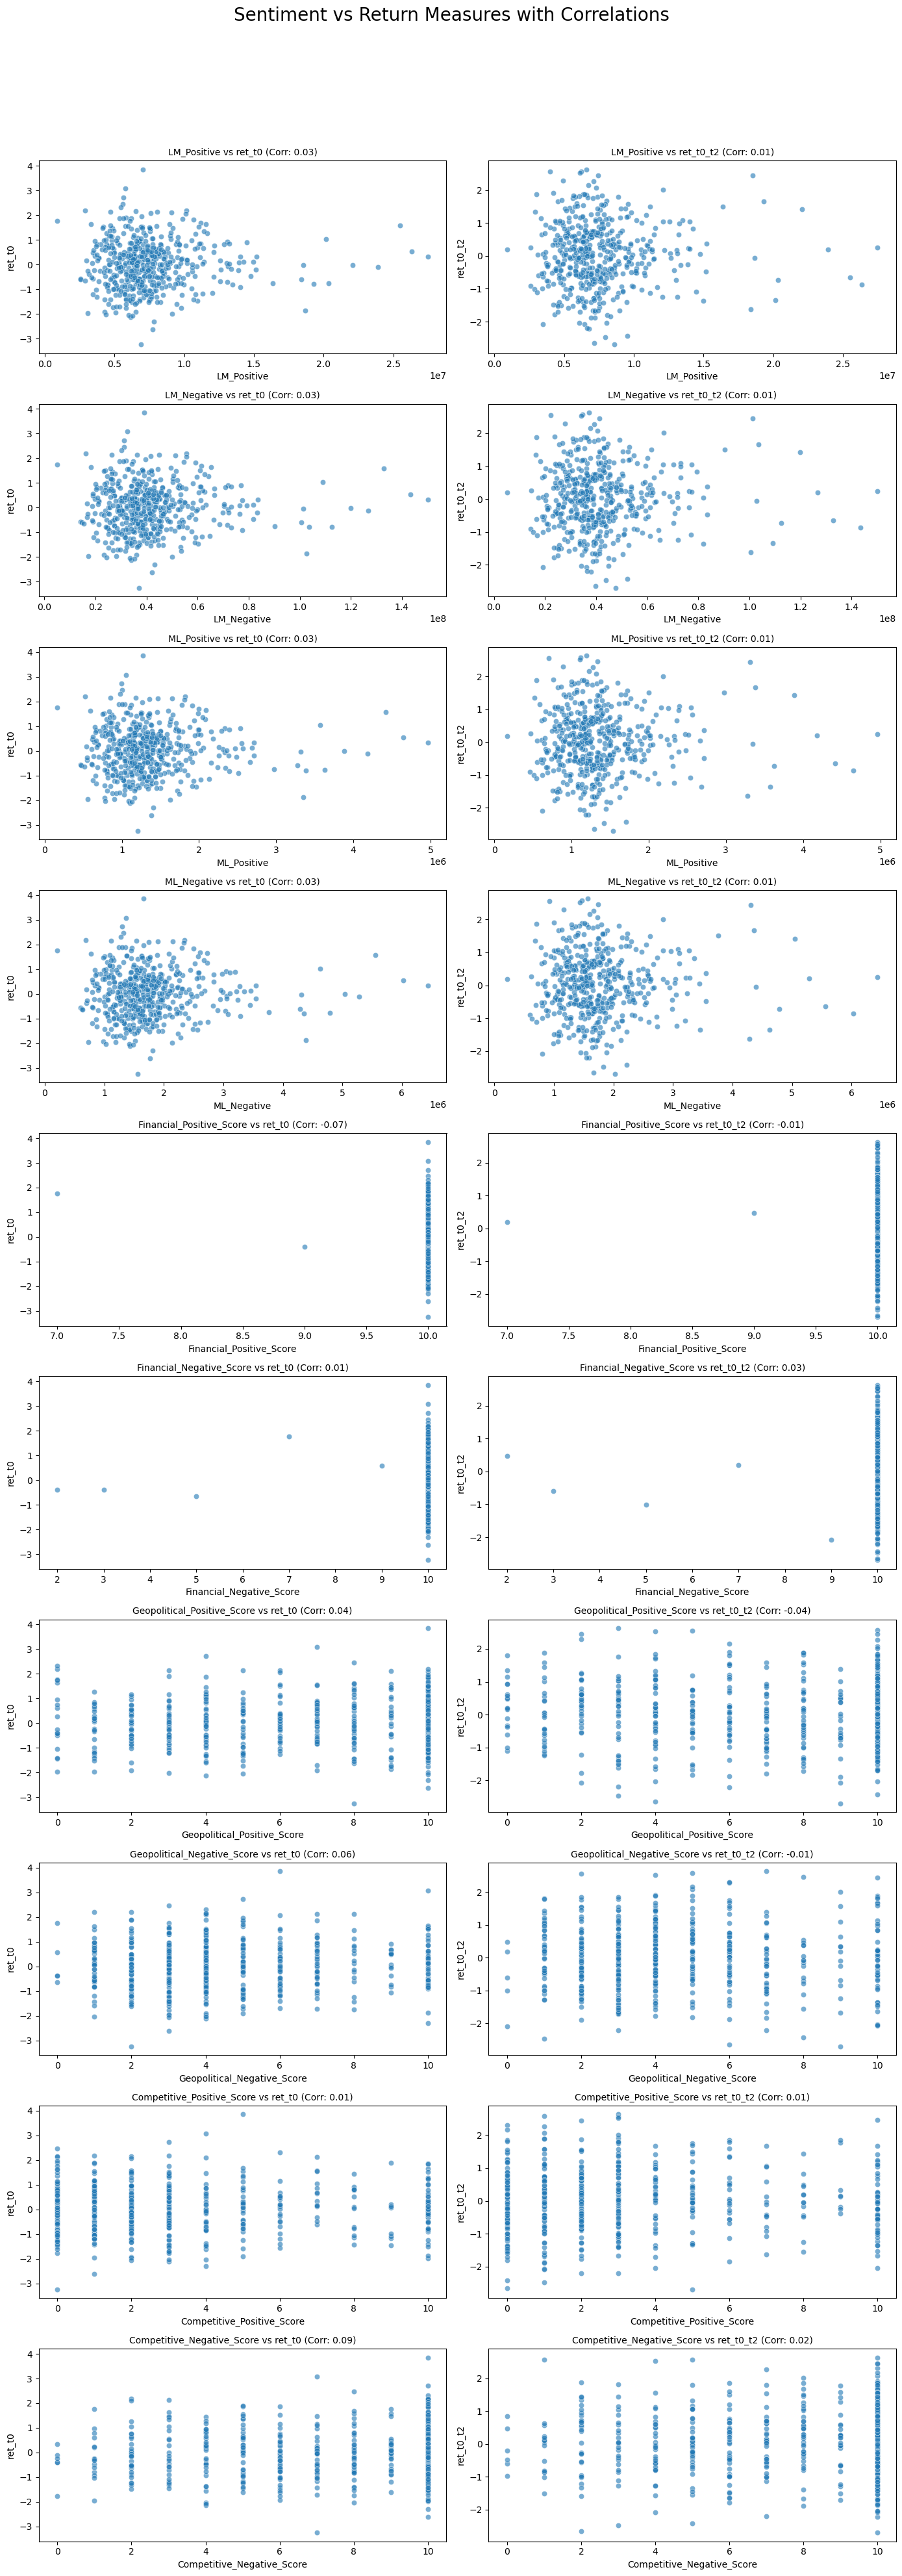

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

#Used online assitance for this plot. I included the correlation figures to compare with the table above

fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(14, 40))
axes = axes.flatten()  # Flatten to make indexing easy
fig.suptitle('Sentiment vs Return Measures with Correlations', fontsize=20, y=1.02)

plot_idx = 0

for sentiment in sentiment_cols:
    for ret in return_cols:
        ax = axes[plot_idx]
        sns.scatterplot(x=df[sentiment], y=df[ret], ax=ax, alpha=0.6)

        corr = df[[sentiment, ret]].corr().iloc[0, 1]
        ax.set_title(f"{sentiment} vs {ret} (Corr: {corr:.2f})", fontsize=10)
        ax.set_xlabel(sentiment)
        ax.set_ylabel(ret)
        plot_idx += 1

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

Discussion

1. LM vs ML Sentiment and returns
   Both the LM and ML sentiment measures show very small correlations with returns on the day of 10-K filing.
   LM_Positive: 0.025
    ML_Positive: 0.027
    LM_Negative: 0.027
    ML_Negative: 0.026
   This shows that positive or negative tone has very little predictive power on the same-day returns in thsi sample. If I was to apply this finding to the real world, firms often use vague or generic language in filings to downplay risk (maybe these words are not being captured by the dictionaries)

2. In Table 3 of Gracia et al., the ML sentiment were showing stronger and more significant relationships with returns. My sample is limited to just one year (2022) and is not as large and complicated as the authors'. I don't believe my results conflict with the Table 3 results, it just shows the difficulty of extracting signal from a small sample with simple metrics.

3. Some contextual measures do show more noticeable correlations:

Geopolitical_Negative_Score: 0.058 with ret_t0
Financial_Positive_Score: -0.070 with ret_t0
Competitive_Negative_Score: 0.092 with ret_t0

The strongest is Competitive_Negative_Score which has a moderately positive correlation of 0.092. This tells me that when firms talk about their competitive pressures negatively, investors might actually think of the firm as being transparent and honest and might actually reward them. Again, my returns were simulated but I would intepret it this way if they were real returns.  Surprisingly, Ginancial_Positive_Score is negatively correlated (-0.070) which reflects the market calling out over optimistic language as a facade. 

4. ML Sentiment and longer time windows (ret_t0_t2, ret_t2_t10)

ML sentiment variables maintain similarly small correlations with longer return timeframes:

ML_Positive: 0.008 (t0_t2), 0.008 (t2_t10)
ML_Negative: 0.009 (t0_t2), 0.009 (t2_t10)

This tells me that any sentiment effect is quickly priced in and that there is no delayed reaction to 10-k tone in days after filing. This supports the efficient market hypothesis. I don't think it would be the case if my returns were real and not simulated. 